# Adding Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


# Getting Districts list from Wikipedia

In [2]:
data = requests.get("http://www.wikizero.biz/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvTGlzdF9vZl9kaXN0cmljdHNfb2ZfSXN0YW5idWw").text

soup = BeautifulSoup(data, 'html.parser')

districtList = []
population = []
densityList = []

soup.find('table').find_all('tr')

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        districtList.append(cells[0].text)
        population.append(cells[1].text)
        densityList.append(cells[3].text.rstrip('\n'))
        

In [3]:
# Creating Table from datas we received
istanbul_df = pd.DataFrame({"District": districtList,
                           "Population": population,
                           "Density": densityList})

istanbul_df = istanbul_df.iloc[:39,:]

In [4]:
istanbul_df.District = istanbul_df.District.str[:-1] # Deleting unncessary ';' char
istanbul_df.Population = istanbul_df.Population.str[:-1] # Deleting unncessary ';' char

In [5]:
# Check Data
istanbul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
District      39 non-null object
Population    39 non-null object
Density       39 non-null object
dtypes: object(3)
memory usage: 1016.0+ bytes


### See Population and Density, their datatypes are object. There is something wrong with it. Let's fix this

In [6]:
istanbul_df["Population"] = istanbul_df["Population"].str.replace(',', '.').astype(np.float64)
istanbul_df.Density = istanbul_df.Density.str.replace(",",".").astype(np.float64)
istanbul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
District      39 non-null object
Population    39 non-null float64
Density       39 non-null float64
dtypes: float64(2), object(1)
memory usage: 1016.0+ bytes


In [7]:
istanbul_df.tail()

,District,Population,Density
34,Şişli,274.289,25.610
35,Tuzla,255.468,2.066
36,Ümraniye,690.193,15.232
37,Üsküdar,529.145,14.977
38,Zeytinburnu,284.935,24.584


# Getting Latitude and Longitude

In [8]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Istanbul, Turkey'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [9]:
coords = [ get_latlng(neighborhood) for neighborhood in istanbul_df.District.tolist() ]

In [10]:
coords[:10]

[[40.87373000000008, 29.12797000000006],
 [41.18558000000007, 28.74147000000005],
 [40.99248000000006, 29.127770000000055],
 [40.97813000000008, 28.721010000000035],
 [41.03323000000006, 28.863510000000076],
 [40.998050000000035, 28.84737000000007],
 [40.98273000000006, 28.87480000000005],
 [41.10745000000003, 28.800610000000063],
 [41.043810000000065, 28.91214000000008],
 [41.041900000000055, 29.005750000000035]]

In [11]:
# Create data frame with latitude and longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [12]:
# Then add them our main dataframe
istanbul_df['Latitude'] = df_coords['Latitude']
istanbul_df['Longitude'] = df_coords['Longitude']

In [13]:
istanbul_df.head()

,District,Population,Density,Latitude,Longitude
0,Adalar,16.119,1.458,40.87373,29.12797
1,Arnavutköy,270.549,600.000,41.18558,28.74147
2,Ataşehir,416.318,16.520,40.99248,29.12777
3,Avcılar,435.625,10.369,40.97813,28.72101
4,Bağcılar,734.369,32.842,41.03323,28.86351


##### Let's find Istanbul coordinates for starting map from there.

In [14]:
address = 'Istanbul, Turkey'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul, Turkey {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul, Turkey 41.0096334, 28.9651646.


###### Plot the map with districts

In [15]:
# 
map_ist = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(istanbul_df['Latitude'], istanbul_df['Longitude'], istanbul_df['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_ist)  
    
map_ist

###### I find house prices data and add them in a list

In [16]:
fiyat_list = [6.728,2.124,4.679,2.239,3.918,3.368,9.396,3.384,3.300,10.834,5.691,2.400,6.636,3.092,2.710,3.102,2.519,2.177,5.086,3.765,3.959,3.004,7.202,3.712,3.389,3.956,3.855,2.786,2.551,9.202,2.279,2.509,2.203,3.890,5.399,2.944,3.530,4.527,3.740]

In [17]:
# Add the house price list in our dataframe
istanbul_df["Avg House Price(m2)"] = fiyat_list
istanbul_df.head()

,District,Population,Density,Latitude,Longitude,Avg House Price(m2)
0,Adalar,16.119,1.458,40.87373,29.12797,6.728
1,Arnavutköy,270.549,600.000,41.18558,28.74147,2.124
2,Ataşehir,416.318,16.520,40.99248,29.12777,4.679
3,Avcılar,435.625,10.369,40.97813,28.72101,2.239
4,Bağcılar,734.369,32.842,41.03323,28.86351,3.918


# Foursquare 

Firstly, we have to pass our client id and client secret for using foursquare API.

In [44]:
CLIENT_ID = 'client-id' # your Foursquare ID
CLIENT_SECRET = 'client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [19]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(istanbul_df['Latitude'], istanbul_df['Longitude'], istanbul_df['District']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In the part above, we call foursquare API for each district and get the venues informations.

In [20]:
# Create dataframe from venues data

venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['District', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(3835, 7)


,District,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adalar,40.87373,29.12797,Splendid Palas Hotel,40.873042,29.126314,Hotel
1,Adalar,40.87373,29.12797,Ada Palas Butik Hotel,40.873586,29.129960,Hotel
2,Adalar,40.87373,29.12797,Büyükada Şekercisi Candy Island Cafe Patisserie,40.873782,29.131028,Breakfast Spot
3,Adalar,40.87373,29.12797,Sarıyer dondurmacısı,40.873561,29.128408,Ice Cream Shop
4,Adalar,40.87373,29.12797,Choco White,40.872910,29.126289,Dessert Shop


In [21]:
# Group them by district
venues_df.groupby(["District"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
District,,,,,,
Adalar,100,100,100,100,100,100
Arnavutköy,46,46,46,46,46,46
Ataşehir,100,100,100,100,100,100
Avcılar,100,100,100,100,100,100
Bahçelievler,100,100,100,100,100,100
Bakırköy,100,100,100,100,100,100
Bayrampaşa,100,100,100,100,100,100
Bağcılar,100,100,100,100,100,100
Başakşehir,100,100,100,100,100,100


As you can see almost each district fill 100 venues threshold. Except Çatalya and Arnavutköy, but number of venues is enough.

In [22]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 290 uniques categories.


In [23]:
venues_df['VenueCategory'].unique()[:10]

array(['Hotel', 'Breakfast Spot', 'Ice Cream Shop', 'Dessert Shop',
       'Café', 'Pub', 'Bed & Breakfast', 'Restaurant', 'Hot Dog Joint',
       'Waterfront'], dtype=object)

In [24]:
"Hotel" in venues_df['VenueCategory'].unique()

True

#### Let's use onehot technique to make venues feature.

In [25]:
ist_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ist_onehot['District'] = venues_df['District'] 

# move neighborhood column to the first column
fixed_columns = [ist_onehot.columns[-1]] + list(ist_onehot.columns[:-1])
ist_onehot = ist_onehot[fixed_columns]

print(ist_onehot.shape)
ist_onehot.head()

(3835, 291)


,District,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Building,Burger Joint,Burrito Place,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Insurance Office,Internet Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Library,Lighthouse,Lingerie Store,Locksmith,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
ist_grouped = ist_onehot.groupby(["District"]).mean().reset_index()

print(ist_grouped.shape)
ist_grouped

(39, 291)


,District,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Building,Burger Joint,Burrito Place,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Insurance Office,Internet Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Library,Lighthouse,Lingerie Store,Locksmith,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place
0,Adalar,0.00,0.01,0.00,0.00,0.000000,0.00,0

In [27]:
len(ist_grouped[ist_grouped["Hotel"] > 0])

27

In [28]:
# Adding house prices as a feature
ist_grouped["Avg House Price(m2)"] = fiyat_list

x = ist_grouped["Avg House Price(m2)"]     # Normalize the house prices
x = (x-np.min(x))/(np.max(x)-np.min(x))    # Normalize the house prices

ist_grouped["Avg House Price(m2)"] = x
ist_grouped.head()

,District,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Building,Burger Joint,Burrito Place,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Insurance Office,Internet Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Library,Lighthouse,Lingerie Store,Locksmith,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place,Avg House Price(m2)
0,Adalar,0.0,0.01,0.0,0.

In [29]:
# Adding density as a feature
ist_grouped["Density"] = istanbul_df["Density"]
x = ist_grouped["Density"] 
x = (x-np.min(x))/(np.max(x)-np.min(x))           # Normalize the density values
ist_grouped["Density"] = x                        # Normalize the density values
ist_grouped.head()

,District,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Buffet,Building,Burger Joint,Burrito Place,Business Center,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Car Wash,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,Hunting Supply,IT Services,Ice Cream Shop,Insurance Office,Internet Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Library,Lighthouse,Lingerie Store,Locksmith,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Event Space,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paintball Field,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilavcı,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racetrack,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shrine,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stadium,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Transportation Service,Travel Agency,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Watch Shop,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Çöp Şiş Place,Avg House Price(m2),Density
0,Adalar,0.0,0.0

In [30]:
# Drop string data from dataframe, cause we can use machine learning algorithm easily
clustring_data = ist_grouped.drop(["District"],1)

##### For finding the best cluster number, lets use inertia graph

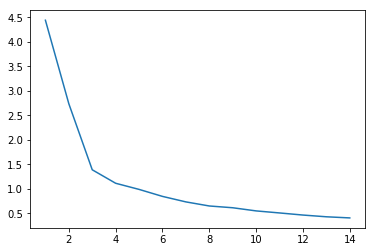

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
wcss = []

for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(clustring_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.show()

According to elbow rule, 3 is the best k value

# K-Means Clustering

In [32]:
kmeans = KMeans(n_clusters=3,random_state=42).fit(clustring_data)

In [33]:
# Check Kmeans labels
kmeans.labels_[0:10]


array([1, 2, 0, 0, 0, 0, 1, 0, 0, 1])

In [34]:
istanbul_merged = istanbul_df.copy()     # Copy the dataframe 
istanbul_merged["Cluster Labels"] = kmeans.labels_   # add labels to copied dataframe

### Find Top 10 venues for each district

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['District', 'Avg House Price(m2)', 'Density']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = ist_grouped['District']
neighborhoods_venues_sorted['Avg House Price(m2)'] = ist_grouped['Avg House Price(m2)']
neighborhoods_venues_sorted['Density'] = ist_grouped['Density']

for ind in np.arange(ist_grouped.shape[0]):
    row_categories = ist_grouped.iloc[ind, :-2].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(39, 13)


,District,Avg House Price(m2),Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,0.528588,0.000000,Hotel,Café,Beach,Boat or Ferry,Breakfast Spot,Bed & Breakfast,Harbor / Marina,Dessert Shop,Seafood Restaurant,Ice Cream Shop
1,Arnavutköy,0.000000,0.755218,Café,Turkish Restaurant,Restaurant,Gym,Fish & Chips Shop,Arcade,Dessert Shop,Diner,Kofte Place,Fast Food Restaurant
2,Ataşehir,0.293341,0.019005,Café,Gym,Park,Pool,Seafood Restaurant,Kebab Restaurant,Coffee Shop,Dance Studio,Breakfast Spot,Pharmacy
3,Avcılar,0.013203,0.011244,Café,Dessert Shop,Gym / Fitness Center,Steakhouse,Coffee Shop,Breakfast Spot,Bar,Gym,Comfort Food Restaurant,Restaurant
4,Bahçelievler,0.205970,0.039599,Café,Turkish Restaurant,Gym,Bakery,Restaurant,Dessert Shop,Seafood Restaurant,Steakhouse,Middle Eastern Restaurant,Burger Joint
5,Bakırköy,0.142824,0.043260,Café,Restaurant,Coffee Shop,Bakery,Gym,Turkish Restaurant,Pizza Place,Fast Food Restaurant,Yoga Studio,Clothing Store
6,Bayrampaşa,0.834902,0.007639,Turkish Restaurant,Café,Gym / Fitness Center,Restaurant,Sporting Goods Shop,Ice Cream Shop,Clothing Store,Coffee Shop,Dessert Shop,Steakhouse
7,Bağcılar,0.144661,0.003335,Café,Gym,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Coffee Shop,Soup Place,Hookah Bar,Convenience Store
8,Başakşehir,0.135017,0.033751,Café,Dessert Shop,Turkish Restaurant,Kebab Restaurant,Restaurant,Gym,Steakhouse,Park,Coffee Shop,Music Venue
9,Beykoz,1.000000,0.010846,Café,Seafood Restaurant,Restaurant,Scenic Lookout,Fish & Chips Shop,Borek Place,Other Great Outdoors,Steakhouse,Fast Food Restaurant,Mountain


In [36]:
# Join to dataframe according to district
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.drop(["Avg House Price(m2)", "Density"], 1).set_index("District"), on="District")

In [37]:
print(istanbul_merged.shape)
istanbul_merged.head()

(39, 17)


,District,Population,Density,Latitude,Longitude,Avg House Price(m2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,16.119,1.458,40.87373,29.12797,6.728,1,Hotel,Café,Beach,Boat or Ferry,Breakfast Spot,Bed & Breakfast,Harbor / Marina,Dessert Shop,Seafood Restaurant,Ice Cream Shop
1,Arnavutköy,270.549,600.000,41.18558,28.74147,2.124,2,Café,Turkish Restaurant,Restaurant,Gym,Fish & Chips Shop,Arcade,Dessert Shop,Diner,Kofte Place,Fast Food Restaurant
2,Ataşehir,416.318,16.520,40.99248,29.12777,4.679,0,Café,Gym,Park,Pool,Seafood Restaurant,Kebab Restaurant,Coffee Shop,Dance Studio,Breakfast Spot,Pharmacy
3,Avcılar,435.625,10.369,40.97813,28.72101,2.239,0,Café,Dessert Shop,Gym / Fitness Center,Steakhouse,Coffee Shop,Breakfast Spot,Bar,Gym,Comfort Food Restaurant,Restaurant
4,Bağcılar,734.369,32.842,41.03323,28.86351,3.918,0,Café,Gym,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Coffee Shop,Soup Place,Hookah Bar,Convenience Store


In [38]:
# Adding Clusters labels
istanbul_merged.sort_values(["Cluster Labels"], inplace=True)
istanbul_merged.head()

,District,Population,Density,Latitude,Longitude,Avg House Price(m2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Fatih,436.539,28.001,41.01958,28.94726,3.765,0,Café,Turkish Restaurant,Restaurant,Hotel,Kebab Restaurant,Dessert Shop,Gym,Steakhouse,Antique Shop,Bakery
20,Gaziosmanpaşa,487.046,41.415,41.05728,28.91605,3.959,0,Café,Turkish Restaurant,Bakery,Gym / Fitness Center,Restaurant,Dessert Shop,Ice Cream Shop,Gym,Coffee Shop,Fast Food Restaurant
21,Güngören,289.331,40.129,41.02205,28.87828,3.004,0,Café,Turkish Restaurant,Restaurant,Department Store,Kebab Restaurant,Pizza Place,Dessert Shop,Women's Store,Gym,Breakfast Spot
23,Kağıthane,437.026,29.389,41.08011,28.97332,3.712,0,Café,Turkish Restaurant,Steakhouse,Coffee Shop,Clothing Store,Park,Restaurant,Gym / Fitness Center,Soccer Field,Kebab Restaurant
24,Kartal,461.155,11.965,40.89064,29.19082,3.389,0,Café,Turkish Restaurant,Seafood Restaurant,Pub,Bar,Doner Restaurant,Gym,Restaurant,Bookstore,Meyhane


### Plotting the map with clustered districts

In [39]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, dist, avg, density, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['District'], istanbul_merged['Avg House Price(m2)'], istanbul_merged['Density'], istanbul_merged['Cluster Labels']):
    label = folium.Popup('{} (AvgHousePrice: {}): Density: {} - Cluster {}'.format(dist, avg, density, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
# Copy the last dataframe to add latitude and longitude
last_df = istanbul_merged.copy()
last_df.drop(["Latitude","Longitude"],1,inplace=True)

# Cluster-1 

In [41]:
last_df.loc[last_df['Cluster Labels'] == 0, last_df.columns[[0] + list(range(1, last_df.shape[1]))]]

,District,Population,Density,Avg House Price(m2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Fatih,436.539,28.001,3.765,0,Café,Turkish Restaurant,Restaurant,Hotel,Kebab Restaurant,Dessert Shop,Gym,Steakhouse,Antique Shop,Bakery
20,Gaziosmanpaşa,487.046,41.415,3.959,0,Café,Turkish Restaurant,Bakery,Gym / Fitness Center,Restaurant,Dessert Shop,Ice Cream Shop,Gym,Coffee Shop,Fast Food Restaurant
21,Güngören,289.331,40.129,3.004,0,Café,Turkish Restaurant,Restaurant,Department Store,Kebab Restaurant,Pizza Place,Dessert Shop,Women's Store,Gym,Breakfast Spot
23,Kağıthane,437.026,29.389,3.712,0,Café,Turkish Restaurant,Steakhouse,Coffee Shop,Clothing Store,Park,Restaurant,Gym / Fitness Center,Soccer Field,Kebab Restaurant
24,Kartal,461.155,11.965,3.389,0,Café,Turkish Restaurant,Seafood Restaurant,Pub,Bar,Doner Restaurant,Gym,Restaurant,Bookstore,Meyhane
25,Küçükçekmece,770.317,20.519,3.956,0,Café,Turkish Restaurant,Coffee Shop,Gym,Gym / Fitness Center,Steakhouse,Seafood Restaurant,Boutique,Arcade,Restaurant
26,Maltepe,497.034,9.383,3.855,0,Café,Turkish Restaurant,Coffee Shop,Seafood Restaurant,Bakery,Pub,Restaurant,Jewelry Store,Cosmetics Shop,Dessert Shop
27,Pendik,693.599,3.853,2.786,0,Café,Fast Food Restaurant,Gym / Fitness Center,Restaurant,Clothing Store,Breakfast Spot,Dessert Shop,Turkish Restaurant,Coffee Shop,Art Gallery
28,Sancaktepe,414.143,6.634,2.551,0,Café,Coffee Shop,Gym,Turkish Restaurant,Pool,Convenience Store,Gym / Fitness Center,Comfort Food Restaurant,Farm,Restaurant
30,Silivri,187.621,215.000,2.279,0,Steakhouse,Seafood Restaurant,Café,Restaurant,Arcade,Dessert Shop,Park,Soup Place,Bakery,Kofte Place


# Cluster- 2

In [42]:
last_df.loc[last_df['Cluster Labels'] == 1, last_df.columns[[0] + list(range(1, last_df.shape[1]))]]

,District,Population,Density,Avg House Price(m2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Beşiktaş,181.074,10.054,10.834,1,Café,Hotel,Coffee Shop,Lounge,Soccer Stadium,Park,Dessert Shop,Spa,Restaurant,Chocolate Shop
29,Sarıyer,342.503,1.952,9.202,1,Seafood Restaurant,Café,Bakery,Steakhouse,Turkish Restaurant,Park,Restaurant,Waterfront,Gym,Hotel
12,Beyoğlu,230.526,25.872,6.636,1,Hotel,Art Gallery,Restaurant,Soccer Stadium,Pizza Place,Nightclub,Scenic Lookout,Theater,Museum,Dessert Shop
6,Bakırköy,222.668,7.512,9.396,1,Café,Restaurant,Coffee Shop,Bakery,Gym,Turkish Restaurant,Pizza Place,Fast Food Restaurant,Yoga Studio,Clothing Store
22,Kadıköy,458.638,18.279,7.202,1,Café,Coffee Shop,Theater,Bar,Pizza Place,Restaurant,Performing Arts Venue,Comic Shop,Italian Restaurant,Dessert Shop
0,Adalar,16.119,1.458,6.728,1,Hotel,Café,Beach,Boat or Ferry,Breakfast Spot,Bed & Breakfast,Harbor / Marina,Dessert Shop,Seafood Restaurant,Ice Cream Shop


# Cluster- 3

In [43]:
last_df.loc[last_df['Cluster Labels'] == 2, last_df.columns[[0] + list(range(1, last_df.shape[1]))]]

,District,Population,Density,Avg House Price(m2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arnavutköy,270.549,600.0,2.124,2,Café,Turkish Restaurant,Restaurant,Gym,Fish & Chips Shop,Arcade,Dessert Shop,Diner,Kofte Place,Fast Food Restaurant
10,Beykoz,246.700,794.0,5.691,2,Café,Seafood Restaurant,Restaurant,Scenic Lookout,Fish & Chips Shop,Borek Place,Other Great Outdoors,Steakhouse,Fast Food Restaurant,Mountain



# Results: 

Cluster 1 = High Density, House Prices below avarage - kinda cheap-, Generally cafe and Turkish restaurants

Cluster 2 = Avagare density, High House prices, Have social areas like art gallery,theater,bar and lounges

Cluster 3 = Very Low density, avarage House prices, generally seafood restaurants,cafe and social activity areas.